### Importing all libraries

In [1]:
import torch, torchvision, torchmetrics
from torchmetrics import ConfusionMatrix
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision import models
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchinfo import summary
from timeit import default_timer as timer
from pathlib import Path
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import random
from PIL import Image
import os
import torchinfo
from torchvision.datasets import ImageFolder
import albumentations as A
from typing import Dict, List
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
print("All packages imported!")

All packages imported!


In [2]:
# GPU information
!nvidia-smi

Sun Apr 28 06:37:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Importing data from our folder

In [4]:
# Setup path tod data folder
dataset_dir = Path("../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/")

# chek if path exists
if dataset_dir.is_dir():
    print("Dataset directory exists\n")
else:
    print("Dataset directory doesnt exist\n")

file_list = list(dataset_dir.glob("*"))
print("Files in the dataset directory")
for file_path in file_list:
    print(file_path.name)

Dataset directory exists

Files in the dataset directory
valid
train


### Defining training and testing directories

In [5]:
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "valid"
train_dir, test_dir

(PosixPath('../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'),
 PosixPath('../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'))

In [6]:
data ='../input/new-plant-diseases-dataset/'
os.listdir(data)

['New Plant Diseases Dataset(Augmented)',
 'new plant diseases dataset(augmented)',
 'test']

### Coverting our train and test directories into datasets

In [7]:
from albumentations.pytorch import ToTensorV2

In [8]:
# Custom dataset class with Albumentations transformations
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []  # Store class names
        
        # Iterate through each class folder
        for label, class_name in enumerate(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_names.append(class_name)  # Append class name
                # Iterate through each image in the class folder
                for image_name in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_name)
                    self.images.append(image_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            transformed = self.transform(image=np.array(image))
            image = transformed['image']
        
        return image, label, self.class_names[label]

# Define additional transformations
additional_transforms = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.2),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.2),
    A.GridDistortion(p=0.2),
])

# Define transformations using Albumentations for training data
train_transform = A.Compose([
    A.RandomResizedCrop(width=256, height=256, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.GaussNoise(p=0.2),
    additional_transforms,  # Add the new transformations here
    A.Normalize(mean=(0.46738179, 0.46738179, 0.46738179), std=(0.19342914, 0.19342914, 0.19342914)),
    A.pytorch.ToTensorV2(),
])

# Define transformations for validation/test data (no augmentation)
val_transform = A.Compose([
    A.Normalize(mean=(0.46738179, 0.46738179, 0.46738179), std=(0.19342914, 0.19342914, 0.19342914)),
    A.pytorch.ToTensorV2(),  # Convert the image to PyTorch tensor without augmentation
])

# Create custom datasets
train_data = CustomDataset(root_dir=train_dir, transform=train_transform)
test_data = CustomDataset(root_dir=test_dir, transform=val_transform)

In [9]:
class_names = train_data.class_names
class_names

['Tomato___Late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Potato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Peach___healthy',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Pepper,_bell___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Strawberry___healthy',
 'Apple___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy'

In [10]:
# Create a dictionary to store class-to-index mapping
class_to_idx = {}

# Assign consecutive indices starting from 0
for idx, class_name in enumerate(class_names):
    class_to_idx[class_name] = idx

# Now you can use the class-to-index mapping
print(class_to_idx)

{'Tomato___Late_blight': 0, 'Tomato___healthy': 1, 'Grape___healthy': 2, 'Orange___Haunglongbing_(Citrus_greening)': 3, 'Soybean___healthy': 4, 'Squash___Powdery_mildew': 5, 'Potato___healthy': 6, 'Corn_(maize)___Northern_Leaf_Blight': 7, 'Tomato___Early_blight': 8, 'Tomato___Septoria_leaf_spot': 9, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 10, 'Strawberry___Leaf_scorch': 11, 'Peach___healthy': 12, 'Apple___Apple_scab': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Bacterial_spot': 15, 'Apple___Black_rot': 16, 'Blueberry___healthy': 17, 'Cherry_(including_sour)___Powdery_mildew': 18, 'Peach___Bacterial_spot': 19, 'Apple___Cedar_apple_rust': 20, 'Tomato___Target_Spot': 21, 'Pepper,_bell___healthy': 22, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 23, 'Potato___Late_blight': 24, 'Tomato___Tomato_mosaic_virus': 25, 'Strawberry___healthy': 26, 'Apple___healthy': 27, 'Grape___Black_rot': 28, 'Potato___Early_blight': 29, 'Cherry_(including_sour)___healthy': 30, 'Co

In [11]:
print(f"Length of train_data: {len(train_data)}\nLength of test_data : {len(test_data)}")

Length of train_data: 70295
Length of test_data : 17572


In [12]:
# Number of cores available on the device
os.cpu_count()

4

### Creating train and test dataloaders

In [13]:
# Setup BATCH_SIZE hyper-parameter
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 2,
                             shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 2,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a151ae10790>,
 <torch.utils.data.dataloader.DataLoader at 0x7a151ae12ec0>)

In [14]:
print(next(iter(train_dataloader))[0].device)
print(next(iter(test_dataloader))[0].device)

cpu
cpu


In [15]:
print(f"Number of train batches: {len(train_dataloader)}\nNumber of test batches : {len(test_dataloader)}")

Number of train batches: 2197
Number of test batches : 550


In [16]:
# img, label = next(iter(train_dataloader))

# # Batch size will now be 1, you can change the batch size if you like
# print(f"Image shape: {img.shape} -> [Batch size, color channels, height, width]")
# print(f"Label shape: {label.shape}")

### Defining a simple model

In [17]:
# setting up device agnostic code
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = models.alexnet(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 146MB/s]  


In [18]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
summary(model, [1,3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 63, 63]           23,296
│    └─ReLU: 2-2                         [1, 64, 63, 63]           --
│    └─MaxPool2d: 2-3                    [1, 64, 31, 31]           --
│    └─Conv2d: 2-4                       [1, 192, 31, 31]          307,392
│    └─ReLU: 2-5                         [1, 192, 31, 31]          --
│    └─MaxPool2d: 2-6                    [1, 192, 15, 15]          --
│    └─Conv2d: 2-7                       [1, 384, 15, 15]          663,936
│    └─ReLU: 2-8                         [1, 384, 15, 15]          --
│    └─Conv2d: 2-9                       [1, 256, 15, 15]          884,992
│    └─ReLU: 2-10                        [1, 256, 15, 15]          --
│    └─Conv2d: 2-11                      [1, 256, 15, 15]         

In [20]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
# Freeze parameters of pre-trained layers to prevent overwriting during fine-tuning:
for param in model.parameters():
    param.requires_grad = False

In [22]:
new_classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),    
    nn.Linear(4096, 38)
)

# Replace the final classifier layers in the pre-trained model
model.classifier = new_classifier
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

In [23]:
model

DataParallel(
  (module): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
   

In [24]:
###############################################################################################
model_state_dict_path = "/kaggle/input/vgg16-75e/VGG16_model_state_dict_75.pth"  # Adjust the filename if needed

# Check if the state dictionary file exists
if os.path.isfile(model_state_dict_path):
    print("Found state dictionary file:", model_state_dict_path)

    # Load the state dictionary
    try:
        model_state_dict = torch.load(model_state_dict_path)
        model.load_state_dict(model_state_dict)
        print("Loaded state dictionary successfully!")
    except Exception as e:
        print(f"Error loading state dictionary: {e}")
else:
    print("No state dictionary file found at", model_state_dict_path)
    
###############################################################################################

No state dictionary file found at /kaggle/input/vgg16-75e/VGG16_model_state_dict_75.pth


In [25]:
loss_fn = torch.nn.CrossEntropyLoss()  # Common choice for multi-class classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Only optimize unfrozen layers, By default it will be requires_grad=True

In [26]:
summary(model, [1,3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [1, 38]                   --
├─AlexNet: 1-1                           [1, 38]                   57,159,526
├─AlexNet: 1-2                           --                        --
│    └─Sequential: 2-1                   [1, 256, 7, 7]            2,469,696
│    └─Sequential: 2-2                   --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 63, 63]           (23,296)
│    │    └─ReLU: 3-2                    [1, 64, 63, 63]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 31, 31]           --
│    │    └─Conv2d: 3-4                  [1, 192, 31, 31]          (307,392)
│    │    └─ReLU: 3-5                    [1, 192, 31, 31]          --
│    │    └─MaxPool2d: 3-6               [1, 192, 15, 15]          --
│    │    └─Conv2d: 3-7                  [1, 384, 15, 15]          (663,936)
│    │    └─ReLU: 3-8                    [1, 384, 

In [27]:
def check_requires_grad(model):
  """
  This function iterates through the model and prints information
  about requires_grad for each module and its parameters.
  """
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(f"{name}: requires_grad=True")
    else:
      print(f"{name}: requires_grad=False")

# Example usage
check_requires_grad(model)

module.features.0.weight: requires_grad=False
module.features.0.bias: requires_grad=False
module.features.3.weight: requires_grad=False
module.features.3.bias: requires_grad=False
module.features.6.weight: requires_grad=False
module.features.6.bias: requires_grad=False
module.features.8.weight: requires_grad=False
module.features.8.bias: requires_grad=False
module.features.10.weight: requires_grad=False
module.features.10.bias: requires_grad=False
module.classifier.1.weight: requires_grad=True
module.classifier.1.bias: requires_grad=True
module.classifier.4.weight: requires_grad=True
module.classifier.4.bias: requires_grad=True
module.classifier.6.weight: requires_grad=True
module.classifier.6.bias: requires_grad=True


### Creating `train_step()` & `test_step()` functions

In [28]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put the model on the training mode
  model.train()

  # setup train loss and accuracy(evaluation metrics)
  train_loss, train_acc = 0, 0

  # loop through the dataloader
  for batch, (X, y, _) in enumerate(dataloader):
    # send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. backprop
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Calculate the accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust the train_loss and train_acc per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [29]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # setup evaluation metrics
  test_loss, test_acc = 0, 0
  cm = ConfusionMatrix(task='multiclass',num_classes=len(class_names)).to(device)

  # set to training mode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y, _) in enumerate(dataloader):
      # put data on target device
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred_logits = model(X)

      # calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        
      # confusion matrix
      cm.update(test_pred_labels, y)

  # Normalize the confusion matrix
  cm = cm.compute().cpu().numpy()
    
  # Calculate precision, recall, and F1-score
  precision = np.diag(cm) / np.sum(cm, axis=0)
  recall = np.diag(cm) / np.sum(cm, axis=1)
  f1 = 2 * (precision * recall) / (precision + recall)
    
  # Average precision, recall, and F1-score across classes
  avg_precision = np.mean(precision)
  avg_recall = np.mean(recall)
  avg_f1 = np.mean(f1)

  # adjust test_loss and test_acc to batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc, cm, avg_precision, avg_recall, avg_f1

In [30]:
num_classes=len(class_names)

In [31]:
num_classes

38

In [32]:
def plot_confusion_matrix(cm, class_names):
    """
    Plots the confusion matrix using Seaborn's heatmap function.
    
    Parameters:
        cm (numpy.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### Creating a `train()` function to combine `train_step()` & `test_step()`

In [33]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5):
    
  #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=lr_scheduler_patience, verbose=True)

  # Create empty results dictionary
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  
  test_confusion_matrices = []  # List to store confusion matrices for each epoch

  # loop through train and test loops for no. of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc, cm, precision, recall, f1  = test_step(model=model,
                                                                dataloader=test_dataloader,
                                                                loss_fn=loss_fn)
    
    
        
    # Update the learning rate based on the test loss
    #scheduler.step(test_loss)
            
    # Print out whats happening
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test Precision: {precision.mean():.4f} | Test Recall: {recall.mean():.4f} | Test F1 Score: {f1.mean():.4f}")
    
    # update the results dictionary
    results["train_loss"].append(train_loss),
    results["train_acc"].append(train_acc),
    results["test_loss"].append(test_loss),
    results["test_acc"].append(test_acc),
    
    # Store confusion matrix for this epoch
    test_confusion_matrices.append(cm)
    

  # Print the final confusion matrix
  print("Final Test Confusion Matrix:\n")
  plot_confusion_matrix(test_confusion_matrices[-1], class_names)

  # Return filled results at the end of the epoch
  return results

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.2079 | Train acc: 0.6562 | Test loss: 0.4641 | Test acc: 0.8551 | Test Precision: 0.8774 | Test Recall: 0.8555 | Test F1 Score: 0.8516
Epoch: 2 | Train loss: 0.5846 | Train acc: 0.8127 | Test loss: 0.2666 | Test acc: 0.9122 | Test Precision: 0.9160 | Test Recall: 0.9125 | Test F1 Score: 0.9103
Epoch: 3 | Train loss: 0.4960 | Train acc: 0.8392 | Test loss: 0.2829 | Test acc: 0.9043 | Test Precision: 0.9145 | Test Recall: 0.9041 | Test F1 Score: 0.9010
Epoch: 4 | Train loss: 0.4433 | Train acc: 0.8560 | Test loss: 0.2347 | Test acc: 0.9194 | Test Precision: 0.9256 | Test Recall: 0.9196 | Test F1 Score: 0.9174
Epoch: 5 | Train loss: 0.4040 | Train acc: 0.8678 | Test loss: 0.1834 | Test acc: 0.9408 | Test Precision: 0.9422 | Test Recall: 0.9411 | Test F1 Score: 0.9399
Epoch: 6 | Train loss: 0.3767 | Train acc: 0.8769 | Test loss: 0.2185 | Test acc: 0.9270 | Test Precision: 0.9328 | Test Recall: 0.9268 | Test F1 Score: 0.9243
Epoch: 7 | Train loss: 0.3596 | Train ac

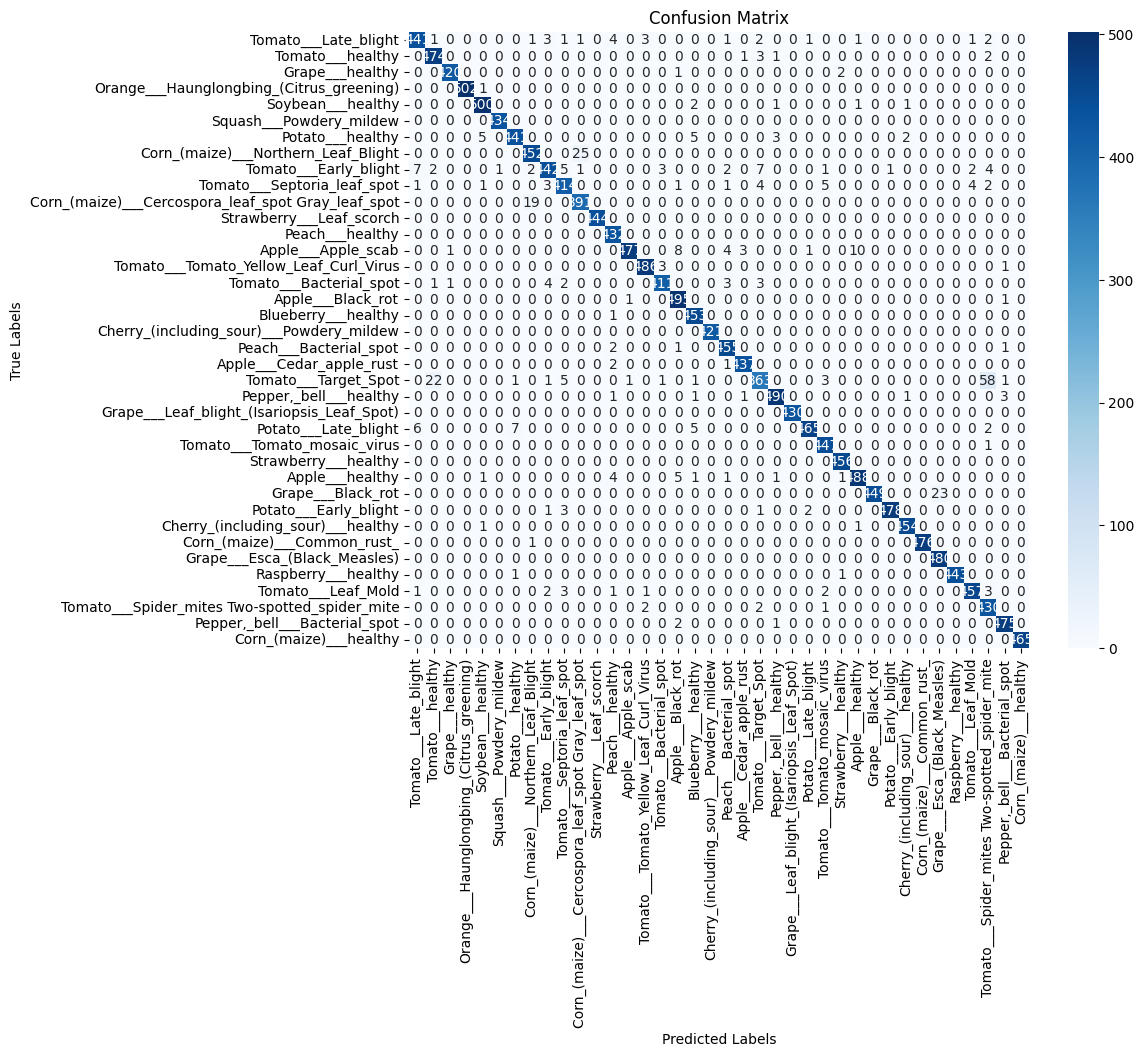

Total training time:  20124.103 seconds


In [34]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the no. of epochs
EPOCHS = 50

# optimizer and loss function are already set way above

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model = model,
          train_dataloader = train_dataloader,
          test_dataloader =  test_dataloader,
          optimizer = optimizer,
          loss_fn = loss_fn,
          epochs = EPOCHS)

# End the timer and print how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time: .3f} seconds")

In [35]:
for batch_data in train_dataloader:
    inputs, labels, class_labels = batch_data
    print("Input tensor shape:", inputs.shape)
    print("Labels tensor shape:", labels.shape)
    print("Class labels:", class_labels)
    break  # Only print the first batch

Input tensor shape: torch.Size([32, 3, 256, 256])
Labels tensor shape: torch.Size([32])
Class labels: ('Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Strawberry___Leaf_scorch', 'Orange___Haunglongbing_(Citrus_greening)', 'Potato___Early_blight', 'Potato___Late_blight', 'Corn_(maize)___healthy', 'Tomato___Tomato_mosaic_virus', 'Potato___Late_blight', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Black_rot', 'Potato___Early_blight', 'Soybean___healthy', 'Tomato___Leaf_Mold', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___Late_blight', 'Potato___Late_blight', 'Apple___Black_rot', 'Apple___Black_rot', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___healthy', 'Tomato___Tomato_mosaic_virus', 'Grape___Black_rot', 'Corn_(maize)___Common_rust_', 'Blueberry___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn_(maize)___Cercospora_leaf_

In [36]:
def plot_curves(results: Dict[str, List[float]]):
  """  plots training curves of a results dictionary  """
  # Get the loss values of the results dictionary (training and testing)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the accuract values of the results dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15,7))

  # plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="Train loss")
  plt.plot(epochs, test_loss, label="Test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="Train Accuracy")
  plt.plot(epochs, test_accuracy, label="Test Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

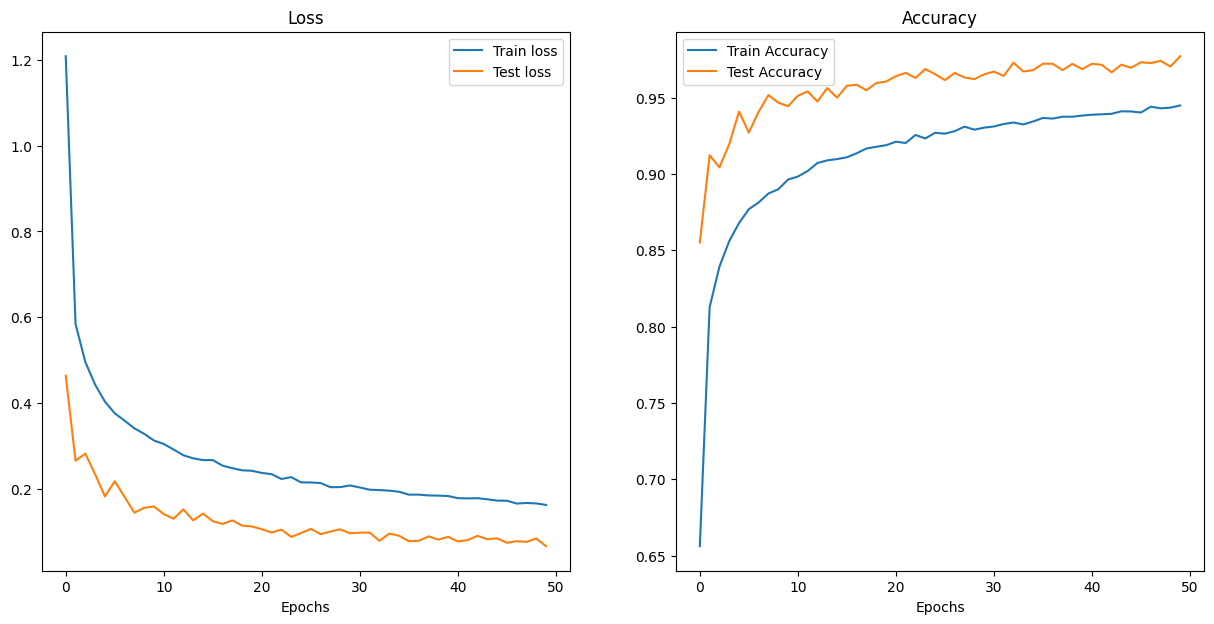

In [37]:
plot_curves(model_0_results)

In [38]:
model_0_results

{'train_loss': [1.2078662187769893,
  0.5846420058443919,
  0.49600206238875133,
  0.4432885835339766,
  0.40398143723261154,
  0.3766895441315529,
  0.35964653853956113,
  0.34175040888946384,
  0.32906005625487134,
  0.31336569794549907,
  0.30532792806761017,
  0.292474324204126,
  0.27905554586617065,
  0.2719262875065472,
  0.26780738108178864,
  0.26782633247117615,
  0.2548418764472618,
  0.24899523870609988,
  0.2440553635191791,
  0.24296811510353913,
  0.2380239985498329,
  0.2350977505398274,
  0.22379698845420948,
  0.22824891841629988,
  0.21599210338674665,
  0.21577351449102394,
  0.21438784763288188,
  0.20479753418474997,
  0.20496741652172473,
  0.2088421863884422,
  0.20410238923254845,
  0.19897885790495748,
  0.19798004891830218,
  0.19674661375232919,
  0.19414888564997443,
  0.18740049635285225,
  0.18745275294814304,
  0.1856190199040904,
  0.1851394977967408,
  0.18421204122055523,
  0.1792204474386389,
  0.17870750185886453,
  0.17917096835841298,
  0.17662181

In [39]:
#####################################################################
model_filename = "/kaggle/working/alexnet_model_state_dict_50.pth"

torch.save(model.state_dict(), model_filename)
print("Model state dictionary exported successfully to", model_filename)
#####################################################################

Model state dictionary exported successfully to /kaggle/working/alexnet_model_state_dict_50.pth
